In [2]:
import os
os.environ["DEVELOPMENT"] = '1'

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent,IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath
import pandas as pd
import numpy as np

INFO:root:Running the simulation in development mode.


c:\Users\s10034cb\Dropbox (The University of Manchester)\Manchester Postdoc\aquacrop\aquacrop\solution\root_zone_water.py:4: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC
INFO:root:"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22000.0\ucrt" "-IC:\Program Files (x86)\W

## Soil fertility calibration

In [3]:
Rel=60
RedaCCx=77
CCx=96

maize = Crop('MaizeGDDAQTEST', planting_date='05/01',need_calib=1,RelativeBio=Rel/100,Ksccx_in=RedaCCx/CCx,fcdecline_in=1)

In [4]:
weather_file_path = get_filepath('cordaba_climate.txt')

In [5]:
IrrMethod=0
irrMet=IrrigationManagement(irrigation_method=IrrMethod)

In [6]:
model_os = AquaCropModel(
            sim_start_time=f'{1986}/05/01',
            sim_end_time=f'{1986}/08/30',
            weather_df=prepare_weather(weather_file_path),
            soil=Soil(soil_type='SandyLoam'),
            crop=maize,
            initial_water_content=InitialWaterContent(value=['FC']),
            irrigation_management=irrMet
        )

In [7]:
model_os._initialize()

print(model_os.crop.Ksccx_in*CCx)
print(100-100*model_os.crop.Ksexpf_es[0])
print(100*model_os.crop.fcdecline_es[0])
print(100-100*model_os.crop.Kswp_es[0])

ValueError: No user-specified soil fertility stress value, no default available.

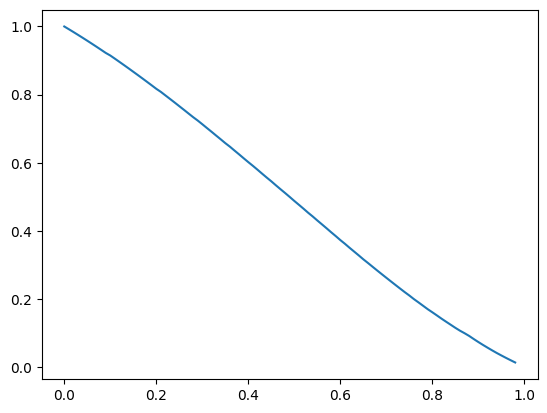

In [ ]:
sf_es=model_os.crop.sf_es
Ksexpf_es=model_os.crop.Ksexpf_es
fcdecline_es=model_os.crop.fcdecline_es
Kswp_es=model_os.crop.Kswp_es
Ksccx_es=model_os.crop.Ksccx_es
relbio_es=model_os.crop.relbio_es

import matplotlib.pyplot as plt
plt.plot(sf_es[1:100], relbio_es[1:100])

## run model

In [ ]:
stress=72#give the value shown in AquaCrop-windows interface for test
IrrMethod=0

loc_=np.argmin(np.abs(sf_es[0:100]-stress/100))

Ksccx=Ksccx_es[loc_]
Ksexpf=Ksexpf_es[loc_]
Kswp=Kswp_es[loc_]
fcdecline=fcdecline_es[loc_]

#to compared with the windows-interface
#for very poor soil fertility stress, this value may be adjusted again during initialization
print(int((1-Ksccx)*100))
print(int((1-Ksexpf)*100))
print(int(fcdecline*10000)/100)
print(int((1-Kswp)*100))

ccx_=(1-Ksccx)*100
cgc_=(1-Ksexpf)*100
dcc_=fcdecline*10000/100
wp_=(1-Kswp)*100

maize = Crop('MaizeGDDAQTEST', planting_date='05/01',Ksccx=1-ccx_/100,Ksexpf=1-cgc_/100,Kswp=1-wp_/100,fcdecline=dcc_/100,\
                 sfertstress=stress/100,sf_es=sf_es,Ksexpf_es=Ksexpf_es,fcdecline_es=fcdecline_es,Kswp_es=Kswp_es,\
                Ksccx_es=Ksccx_es,relbio_es=relbio_es)


irrMet=IrrigationManagement(irrigation_method=IrrMethod)

model_os = AquaCropModel(
            sim_start_time=f'{1986}/05/01',
            sim_end_time=f'{1986}/08/30',
            weather_df=prepare_weather(weather_file_path),
            soil=Soil(soil_type='SandyLoam'),
            crop=maize,
            initial_water_content=InitialWaterContent(value=['FC']),
            irrigation_management=irrMet
        )


51
40
0.29
82


In [ ]:
model_os.run_model(till_termination=True)
model_results = model_os.get_crop_growth()

TypeError: cannot unpack non-iterable Crop object

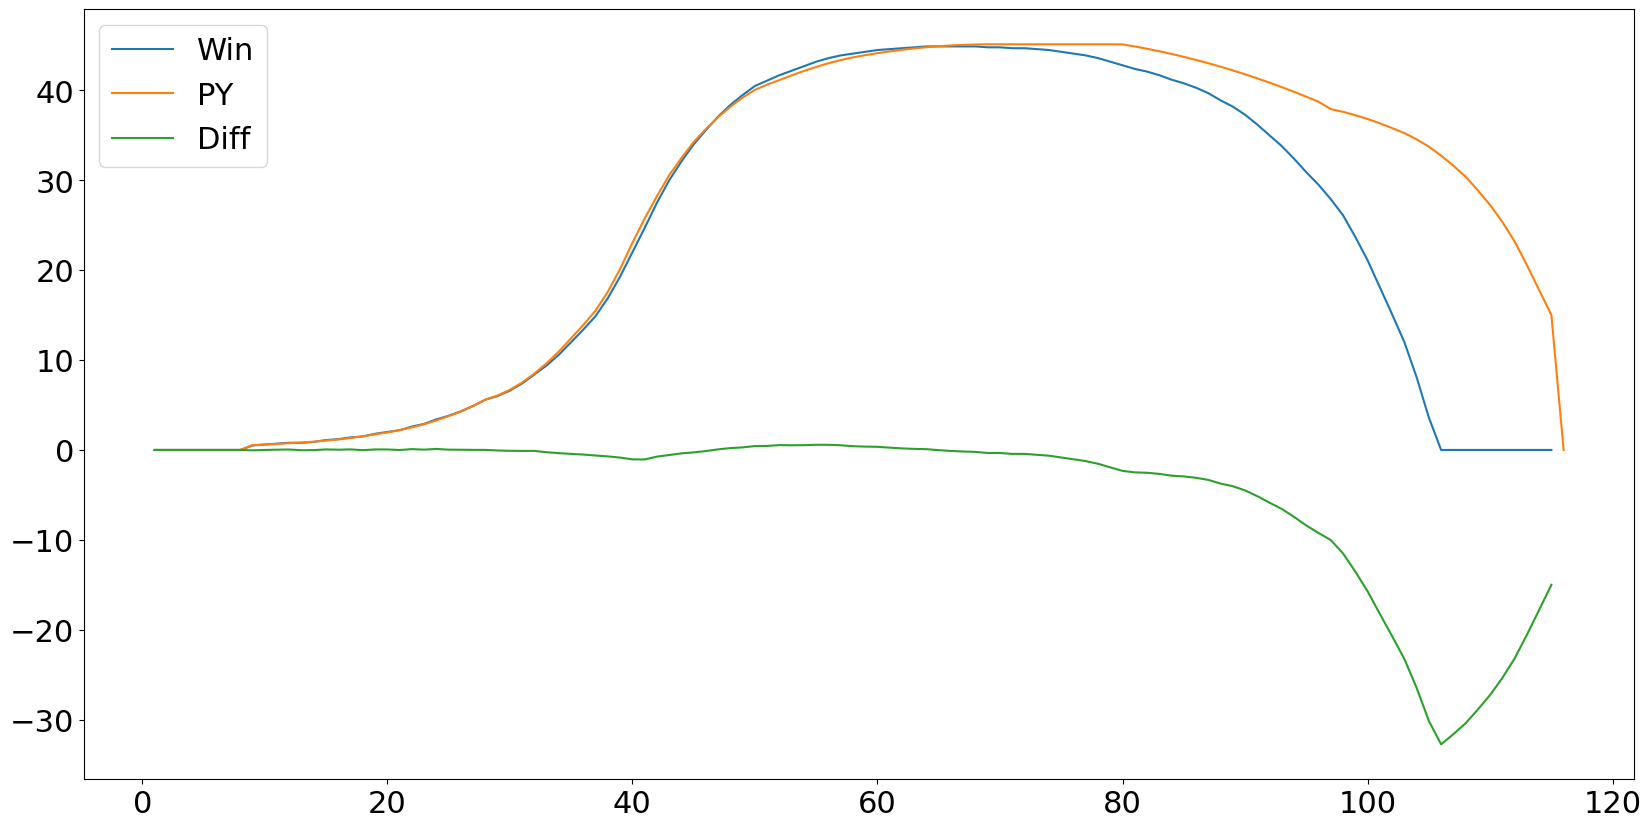

<Figure size 640x480 with 0 Axes>

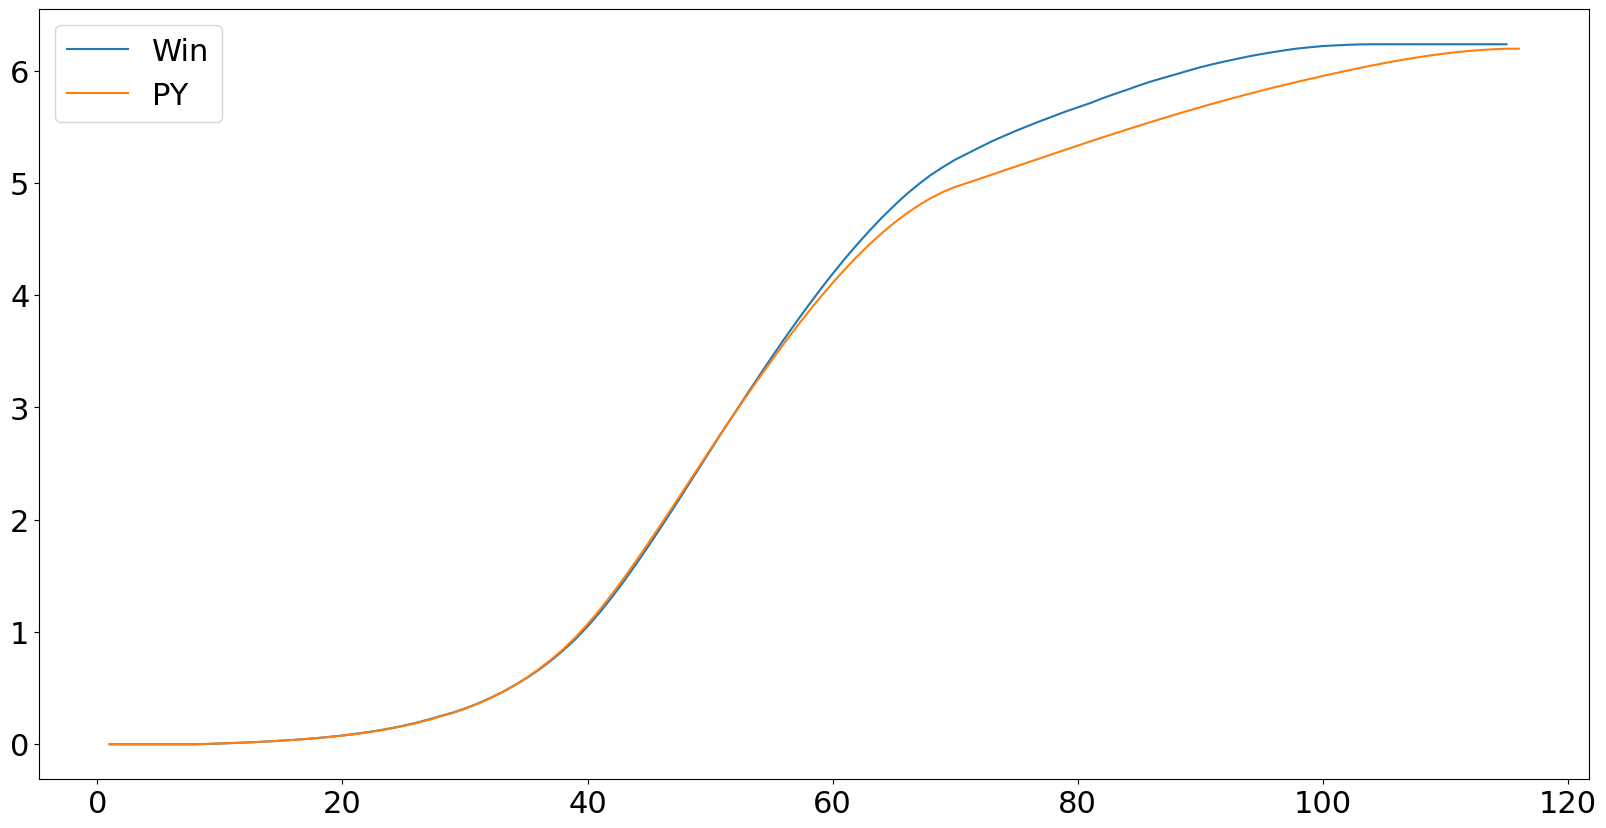

<Figure size 640x480 with 0 Axes>

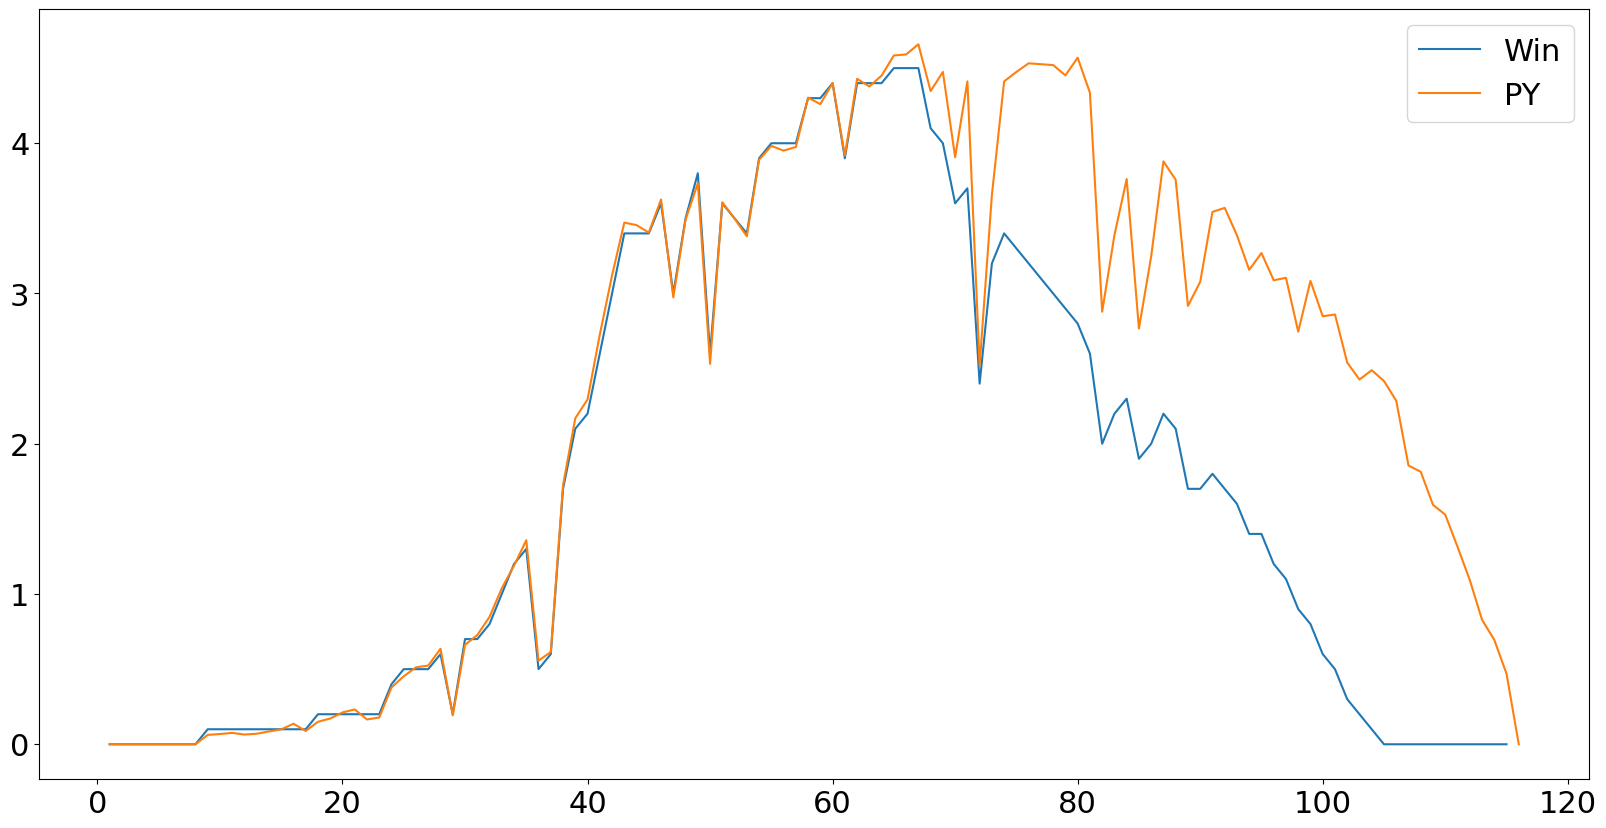

<Figure size 640x480 with 0 Axes>

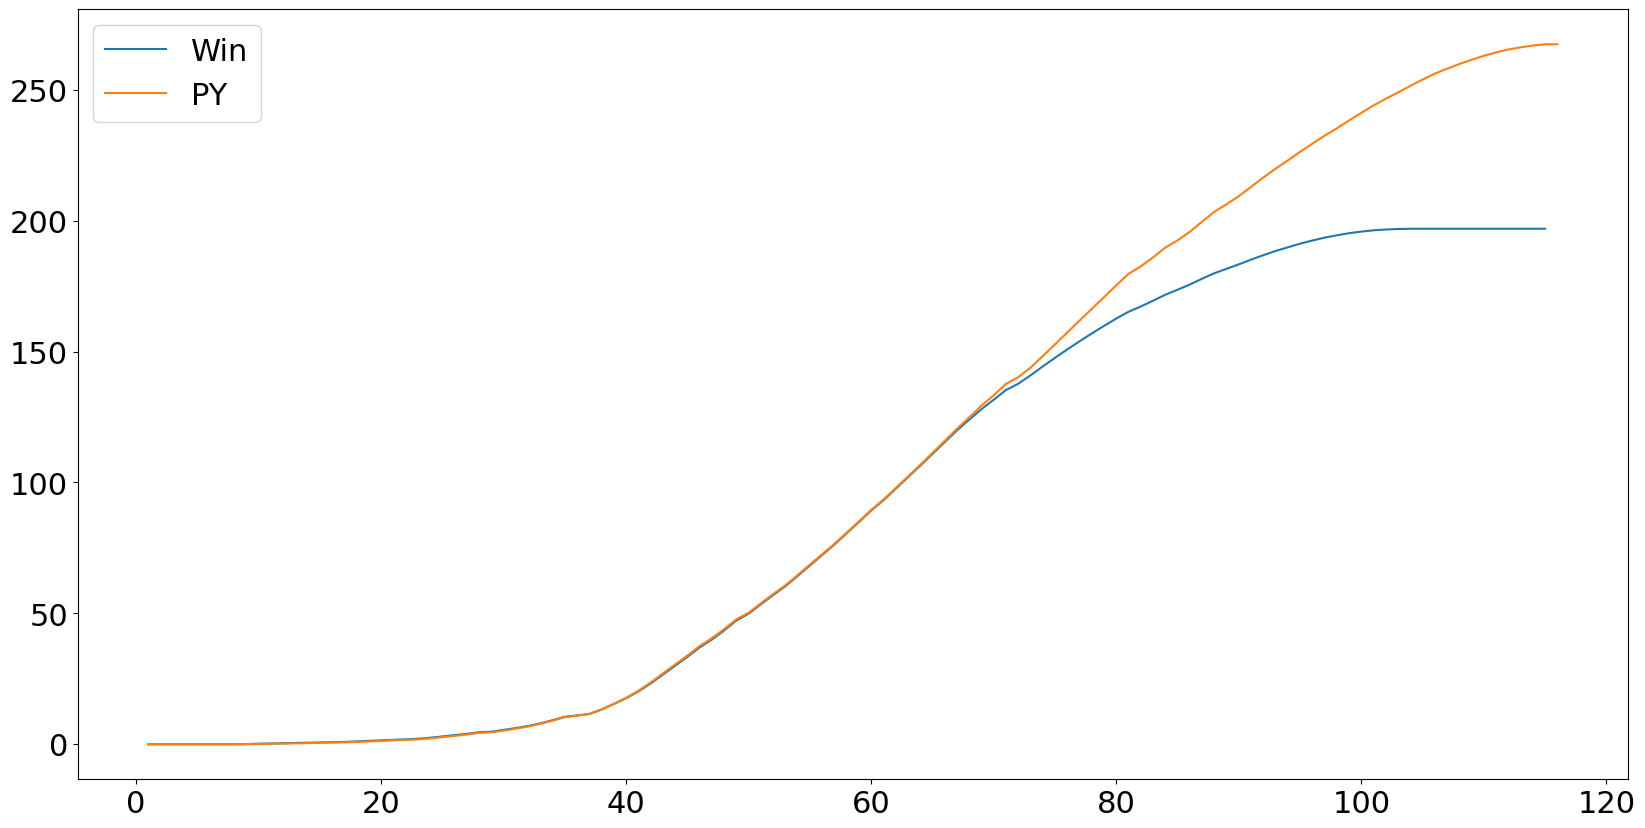

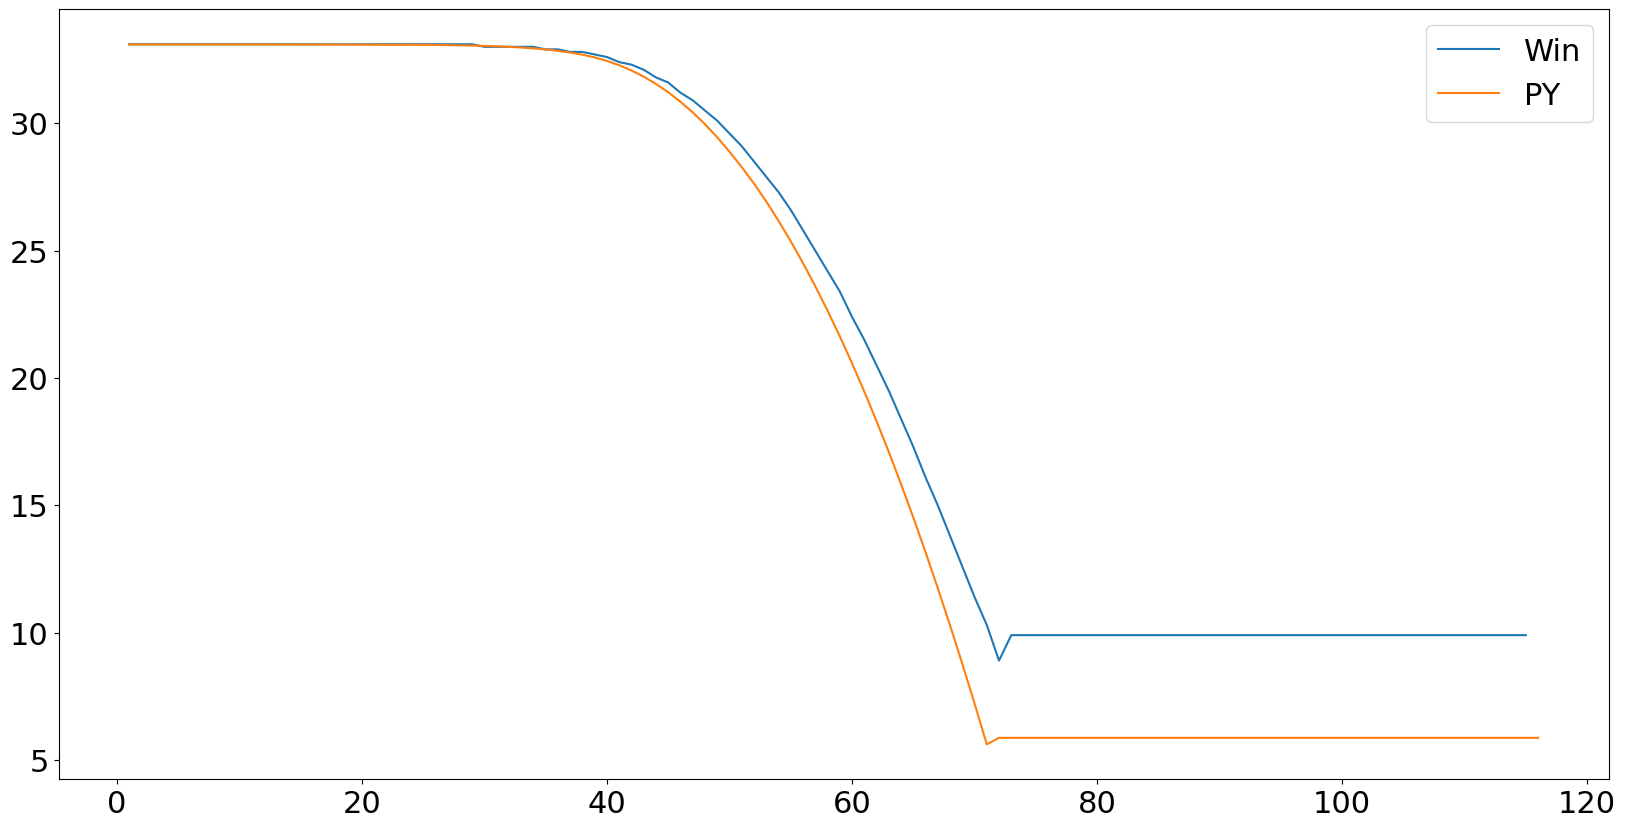

In [ ]:
aq=pd.read_table('AquaCropV61Nr02052018\SIMUL\Crop.OUT',skiprows=4, delim_whitespace=True,encoding="latin1")
aq=aq.drop([0])

aq.to_csv('aq_temp.csv')

aq=pd.read_csv('aq_temp.csv')

import matplotlib.pyplot as plt

aq

time=np.array(range(1,len(aq.index)))
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'CC'],label='Win')
plt.plot(time,model_results.loc[time,'canopy_cover']*100,label='PY')
plt.plot(time,aq.loc[time,'CC']-model_results.loc[time,'canopy_cover']*100,label='Diff')
plt.legend()
plt.savefig('test_figs\maize_CCx_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Biomass'],label='Win')
plt.plot(time,model_results.loc[time,'biomass']/100,label='PY')
plt.legend()
plt.savefig('test_figs\maize_Biomass_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Tr'],label='Win')
plt.plot(time,model_results.loc[time,'Tr'],label='PY')
plt.legend()

import itertools
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,list(itertools.accumulate(aq.loc[time,'Tr'])),label='Win')
plt.plot(time,list(itertools.accumulate(model_results.loc[time,'Tr'])),label='PY')
plt.legend()
plt.savefig('test_figs\maize_Traccum_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

#time=range(1,175)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'WP'],label='Win')
plt.plot(time,model_results.loc[time,'NewCond.WPadj'],label='PY')
plt.legend()
plt.savefig('test_figs\maize_WPadj_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()